In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

*Import data*

In [145]:
tickers = ['TSLA','GOOGL', 'AMZN','PLTR', 'SHOP', 'SNOW', 'NVDA']

for ticker in tickers:
    data = yf.download(tickers, start="2020-10-01", end="2022-01-01")
    data = data['Close']
    simple_returns = data.pct_change()
    simple_returns = simple_returns.dropna()
    simple_returns.head()

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed


In [146]:
mean_returns = simple_returns.mean()
print(mean_returns)
covariance_matrix = simple_returns.cov()
print(covariance_matrix)

AMZN     0.000317
GOOGL    0.002282
NVDA     0.002835
PLTR     0.003207
SHOP     0.001422
SNOW     0.001631
TSLA     0.003458
dtype: float64
           AMZN     GOOGL      NVDA      PLTR      SHOP      SNOW      TSLA
AMZN   0.000272  0.000148  0.000263  0.000150  0.000276  0.000200  0.000190
GOOGL  0.000148  0.000249  0.000210  0.000075  0.000161  0.000161  0.000138
NVDA   0.000263  0.000210  0.000757  0.000334  0.000449  0.000428  0.000398
PLTR   0.000150  0.000075  0.000334  0.002392  0.000451  0.000663  0.000629
SHOP   0.000276  0.000161  0.000449  0.000451  0.000965  0.000506  0.000377
SNOW   0.000200  0.000161  0.000428  0.000663  0.000506  0.001384  0.000469
TSLA   0.000190  0.000138  0.000398  0.000629  0.000377  0.000469  0.001221


In [147]:
weights = np.random.random(len(simple_returns.columns))
weights /= np.sum(weights)
print(weights)

[0.04362619 0.24954795 0.15993996 0.06694647 0.02070891 0.25567273
 0.20355779]


In [148]:
simple_returns['portfolio'] = simple_returns.dot(weights)
print(simple_returns)

                AMZN     GOOGL      NVDA      PLTR      SHOP      SNOW  \
Date                                                                     
2020-10-01  0.023035  0.015216  0.006208 -0.004211  0.030754 -0.030040   
2020-10-02 -0.029883 -0.021708 -0.040563 -0.027484 -0.024127 -0.067198   
2020-10-05  0.023744  0.018707  0.044422 -0.018478  0.035511  0.056803   
2020-10-06 -0.031020 -0.021452  0.006890  0.096346 -0.022787  0.021250   
2020-10-07  0.030881  0.005596  0.016562  0.010101  0.030905  0.003672   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.008178  0.006738  0.044028  0.000528 -0.026915  0.007932   
2021-12-28  0.005844 -0.008245 -0.020133 -0.019535 -0.017828 -0.033552   
2021-12-29 -0.008555 -0.000218 -0.010586 -0.021540  0.011965  0.011847   
2021-12-30 -0.003289 -0.003099 -0.013833  0.028619  0.004425 -0.010401   
2021-12-31 -0.011429 -0.009224 -0.005915 -0.025682 -0.014912 -0.005519   

                TSLA  portfolio  
Dat

# Historical VaR and CVaR

The historical simulation method assumes that the past performance of a portfolio is a good indicator of its performance in the near future. This method reorganizes actual historical returns by ranking them from the worst to the best. It assumes the recurrence of the trend, from a risk perspective

Unlike the other two methods, the historical simulation method does not need any distributional assumption to estimate VaR.

In [149]:
# Calculate historical VaR(95)
portfolio_returns = simple_returns['portfolio']
var_95 = np.percentile(portfolio_returns, 5)
print('The historical VaR is:', var_95, "%")
cvar_95 = portfolio_returns[portfolio_returns <= var_95].mean()
print('The historical CVaR is:', cvar_95, "%")
cvar_95_min = portfolio_returns[portfolio_returns <= var_95].min()
print('Max historical loss:', cvar_95_min, "%")

# Sort the returns for plotting
sorted_rets = portfolio_returns.sort_values(ascending=True)

InitialInvestment = 10000
print('Value at Risk 95th CI in $    :      ', round(InitialInvestment*var_95,2), "$")
print('Conditional VaR 95th CI in $  :      ', round(InitialInvestment*cvar_95,2), "$")

The historical VaR is: -0.03461782167745729 %
The historical CVaR is: -0.04627144605659572 %
Max historical loss: -0.0669272629118304 %
Value at Risk 95th CI in $    :       -346.18 $
Conditional VaR 95th CI in $  :       -462.71 $


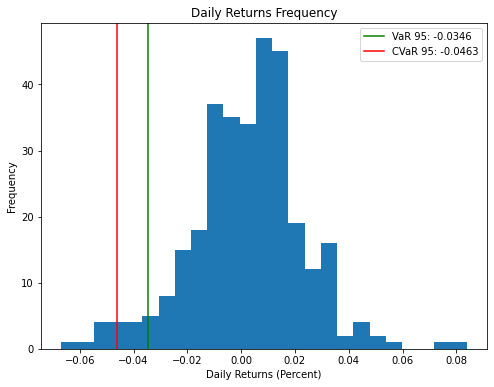

In [150]:
plt.figure(figsize=(8,6))
plt.hist(sorted_rets, bins=25)
plt.title('Daily Returns Frequency')
plt.xlabel('Daily Returns (Percent)')
plt.ylabel('Frequency')
plt.axvline(x=var_95, color='green', label='VaR 95: %0.4f' % var_95)  # plot the historical VaR on the histogram
plt.axvline(x=cvar_95, color='red', label='CVaR 95: %0.4f' % cvar_95)  # plot the historical CVar on the histogram
plt.legend()
plt.show()

In [151]:
# Creating a column where the portfolio returns were below the VaR_95
simple_returns["violations"] = portfolio_returns[portfolio_returns <= var_95]
violations = simple_returns["violations"]
violations[violations <= 0] = 1
violations = violations.replace(np.nan, 0)
print(violations.value_counts())

0.0    300
1.0     16
Name: violations, dtype: int64


Kupiec Test (1995): verify if the number of violations is consistent with the violations predicted by the model;

In [152]:
import vartests

vartests.kupiec_test(violations, var_conf_level=0.95, conf_level=0.95)

{'statictic test': 0.0026543047232116096,
 'chi square value': 0.04108879078250403,
 'null hypothesis': 'Probability of failure is 0.05',
 'result': 'Fail to reject H0'}

The results suggest that the var model introduced allows to identify the falilure rate.

Christoffersen and Pelletier Test (2004): also known as Duration Test. Duration is time between violations of VaR. It tests if VaR Model has quickly response to market movements by consequence the violations do not form volatility clusters. This test verifies if violations has no memory i.e. should be independent.

In [153]:
vartests.duration_test(violations, conf_level=0.95)

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


{'weibull exponential': array([0.85282878]),
 'unrestricted log-likelihood': array([-57.1130652]),
 'restricted log-likelihood': -57.45588099561191,
 'log-likelihood': array([0.68563158]),
 'log-likelihood ratio test statistic': array([0.40765423]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

In [154]:
vartests.failure_rate(violations)

Failure rate of 5.06%


0.05063291139240506

Based on the failure rate, the historical VaR is adquate. In fact, it corresponds to the 5% used with the CL=95%.

*Historical VaR and CVaR for the 100 recent days*

In [155]:
tail_returns = portfolio_returns.tail(100)
print(tail_returns)
var95_100 = np.percentile(tail_returns, 5)
print('The var for the 100 recent days is: %0.4f' % var95_100, "%")
cvar95_100 = tail_returns[tail_returns <= var95_100].mean()
print('The cvar for the 100 recent days is: %0.4f' % cvar95_100, "%")
cvar_95_min = portfolio_returns[portfolio_returns <= var_95].min()
print('Max historical 100 day loss:', cvar_95_min, "%")

InitialInvestment = 10000
print('Value at Risk 95th CI in $   :      ', round(InitialInvestment*var95_100,2), "$")
print('Conditional VaR 95th CI in $ :      ', round(InitialInvestment*cvar95_100,2), "$")

Date
2021-08-11   -0.004794
2021-08-12    0.025155
2021-08-13    0.006322
2021-08-16   -0.018964
2021-08-17   -0.019067
                ...   
2021-12-27    0.015012
2021-12-28   -0.016296
2021-12-29   -0.000713
2021-12-30   -0.006751
2021-12-31   -0.009764
Name: portfolio, Length: 100, dtype: float64
The var for the 100 recent days is: -0.0346 %
The cvar for the 100 recent days is: -0.0423 %
Max historical 100 day loss: -0.0669272629118304 %
Value at Risk 95th CI in $   :       -345.66 $
Conditional VaR 95th CI in $ :       -423.31 $


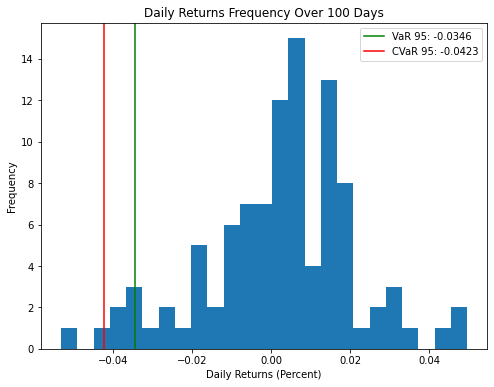

In [156]:
plt.figure(figsize=(8,6))
plt.hist(tail_returns, bins=25)
plt.title('Daily Returns Frequency Over 100 Days')
plt.xlabel('Daily Returns (Percent)')
plt.ylabel('Frequency')
plt.axvline(x=var95_100, color='green', label='VaR 95: %0.4f' % var95_100)  # plot the historical VaR on the histogram
plt.axvline(x=cvar95_100, color='red', label='CVaR 95: %0.4f' % cvar95_100)  # plot the historical CVar on the histogram
plt.legend()
plt.show()

# Parametric VaR and CVaR

The parametric method is also called the variance-covariance method. This method looks at the price changes of an investment over a lookback period and computes a portfolio’s maximum loss using probability theory. It uses the standard deviation and the mean of the price returns of an asset (in this case of a portfolio) as the parameters. The maximum loss within a specific confidence level is calculated, assuming asset price returns and volatility follow a normal distribution.

In [157]:
from scipy.stats import norm, t

In [158]:
portfolio_mean_return = portfolio_returns.mean()
print(portfolio_mean_return)
portfolio_std = portfolio_returns.std()
print(portfolio_std)

0.0024018323799952176
0.020706264851365584


In [159]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        x = dof
        VaR = np.sqrt((x-2)/x) * t.ppf(1-alpha/100, x) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

In [160]:
def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))* portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        y = dof
        z = t.ppf(alpha/100, y)
        CVaR = -1/(alpha/100) * (1-y)**(-1) * (y-2+z**2) * t.pdf(z, y) * portfolioStd - portfolio_mean_return
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

In [161]:
normal_VaR = var_parametric(portfolio_mean_return, portfolio_std, distribution='normal')
normal_CVaR = cvar_parametric(portfolio_mean_return, portfolio_std, distribution='normal')

normal_VaR = -normal_VaR

tVaR = var_parametric(portfolio_mean_return, portfolio_std, distribution='t-distribution')
tCVaR = cvar_parametric(portfolio_mean_return, portfolio_std, distribution='t-distribution')

tVaR = -tVaR

print("Normal VaR 95th CI in $       :      ", round(InitialInvestment*normal_VaR,2), "$")
print("Normal CVaR 95th CI in $      :      ", round(InitialInvestment*normal_CVaR,2), "$")
print("t-dist VaR 95th CI in $       :      ", round(InitialInvestment*tVaR,2), "$")
print("t-dist CVaR 95th CI in $      :      ", round(InitialInvestment*tCVaR,2), "$")

Normal VaR 95th CI in $       :       -316.57 $
Normal CVaR 95th CI in $      :       403.09 $
t-dist VaR 95th CI in $       :       -304.51 $
t-dist CVaR 95th CI in $      :       422.44 $


In [162]:
simple_returns['normal_violations'] = simple_returns['portfolio'] <= normal_VaR
simple_returns['normal_violations']= simple_returns['normal_violations'].astype(float)
simple_returns['normal_violations'].replace('False', 0)
simple_returns['normal_violations'].replace('True', 1)
violations_normal= simple_returns['normal_violations']
print(violations_normal.value_counts())
print(violations_normal.unique())
print(violations_normal.describe())

0.0    298
1.0     18
Name: normal_violations, dtype: int64
[0. 1.]
count    316.000000
mean       0.056962
std        0.232138
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: normal_violations, dtype: float64


In [163]:
vartests.kupiec_test(violations_normal, var_conf_level=0.95, conf_level=0.95)

{'statictic test': 0.30918755747831544,
 'chi square value': 0.42182083909290136,
 'null hypothesis': 'Probability of failure is 0.05',
 'result': 'Fail to reject H0'}

In [164]:
vartests.failure_rate(violations_normal)

Failure rate of 5.7%


0.056962025316455694

In [165]:
simple_returns['t_violations'] = simple_returns['portfolio'] <= tVaR
simple_returns['t_violations']= simple_returns['t_violations'].astype(float)
simple_returns['t_violations'].replace('False', 0)
simple_returns['t_violations'].replace('True', 1)
violations_t= simple_returns['t_violations']
print(violations_t.value_counts())
print(violations_t.unique())
print(violations_t.describe())

0.0    297
1.0     19
Name: t_violations, dtype: int64
[0. 1.]
count    316.000000
mean       0.060127
std        0.238098
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: t_violations, dtype: float64


In [166]:
vartests.kupiec_test(violations_t, var_conf_level=0.95, conf_level=0.95)

{'statictic test': 0.6425359314565243,
 'chi square value': 0.5772060111969168,
 'null hypothesis': 'Probability of failure is 0.05',
 'result': 'Fail to reject H0'}

In [167]:
vartests.failure_rate(violations_t)

Failure rate of 6.01%


0.060126582278481014

# Monte carlo daily VaR

Monte Carlo simulation is a method that randomly generates trials without providing any information about the underlying methodology. This method of VaR computation is somewhat similar to the historical simulation method. However, Monte Carlo simulation generates random numbers to estimate the return of an asset. It neither uses historical data of returns nor assumes a recurrence.

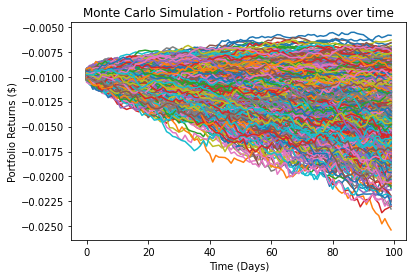

The monte carlo parametric VaR(95):  -3.15 %
The monte carlo parametric VaR(95): -314.7 $


In [168]:
number_simulations = 2500
T = 100 # forecast period 
S0 = portfolio_returns.iloc[-1] # Most recent return

# Aggregate the returns
sim_returns = []

# Loop through 2500 simulations
for i in range(number_simulations):

    # Generate the Random Walk
    rand_rets = np.random.normal(portfolio_mean_return, portfolio_std, T) 
    sim_returns.append(rand_rets)
    cumulative_returns = rand_rets + 1
    forecast_returns = S0 * (cumulative_returns.cumprod())

    plt.plot(forecast_returns)
    plt.title('Monte Carlo Simulation - Portfolio returns over time')
    plt.xlabel('Time (Days)')
    plt.ylabel('Portfolio Returns ($)')
plt.show()

# Calculate the VaR(95)
mvar_95 = np.percentile(sim_returns, 5)
print("The monte carlo parametric VaR(95): ", round(100*mvar_95, 2),"%")
print("The monte carlo parametric VaR(95):", round(InitialInvestment*mvar_95,2),"$")

# Monte Carlo in the end of 100 days

In [169]:
mc_sims = 2500 # number of simulations
T = 100 #timeframe in days
meanM = np.full(shape=(T, len(weights)), fill_value=portfolio_mean_return)
meanM = meanM.T
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
initialPortfolio = 10000
for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covariance_matrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*InitialInvestment

<function matplotlib.pyplot.show(close=None, block=None)>

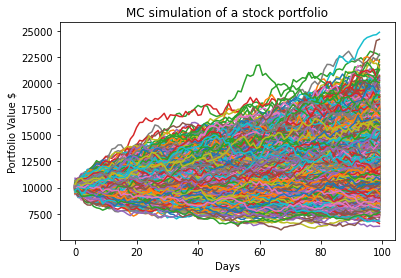

In [170]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value $')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show

In [171]:
# Using only the last value of the forecast for calculating VaR
portResults = pd.Series(portfolio_sims[-1,:])
print(portResults.head())
VaR_MC = np.percentile(portResults, 5)
print(VaR_MC)
belowVaR = portResults[portResults <= VaR_MC]
print(belowVaR.head())
CVaR_MC = sum(belowVaR)/len(belowVaR)
print(CVaR_MC)
mVaR = initialPortfolio - VaR_MC
mCVaR = initialPortfolio - CVaR_MC
print('VaR ${}'.format(round(mVaR,2)))
print('CVaR ${}'.format(round(mCVaR,2)))

0    18739.040424
1     8745.358123
2    14138.339862
3    12694.134726
4    11380.037538
dtype: float64
8722.8355661939
37     8090.865195
80     8016.765059
95     8482.339563
113    7948.582475
128    7637.939984
dtype: float64
8008.140608460945
VaR $1277.16
CVaR $1991.86


In [172]:
portResults = pd.Series(portfolio_sims[-1,:])
df_mc = portResults.to_frame(name = "portResults")
print(df_mc)

       portResults
0     18739.040424
1      8745.358123
2     14138.339862
3     12694.134726
4     11380.037538
...            ...
2495  10142.830413
2496   8030.214241
2497  14199.288319
2498  15560.437992
2499  12882.469702

[2500 rows x 1 columns]


In [173]:
print(belowVaR)

37      8090.865195
80      8016.765059
95      8482.339563
113     7948.582475
128     7637.939984
           ...     
2469    6815.556280
2472    7655.418132
2478    8474.742459
2481    8505.342003
2496    8030.214241
Length: 125, dtype: float64


Backtesting Monte Carlo VaR 

In [174]:
df_mc["violations_mc"] = df_mc['portResults'] <= VaR_MC
df_mc["violations_mc"]= df_mc["violations_mc"].astype(float)
df_mc["violations_mc"].replace('False', 0)
df_mc["violations_mc"].replace('True', 1)
mc_violations = df_mc["violations_mc"]
print(mc_violations.value_counts())
print(mc_violations.describe())

0.0    2375
1.0     125
Name: violations_mc, dtype: int64
count    2500.000000
mean        0.050000
std         0.217989
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: violations_mc, dtype: float64


In [175]:
vartests.kupiec_test(mc_violations, var_conf_level=0.95, conf_level=0.95)

{'statictic test': -0.0,
 'chi square value': 0.0,
 'null hypothesis': 'Probability of failure is 0.05',
 'result': 'Fail to reject H0'}

In [176]:
vartests.duration_test(mc_violations, conf_level=0.95)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


{'weibull exponential': array([1.09223017]),
 'unrestricted log-likelihood': array([-491.93043073]),
 'restricted log-likelihood': -492.6714784637646,
 'log-likelihood': array([1.48209546]),
 'log-likelihood ratio test statistic': array([0.22344696]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

In [177]:
vartests.failure_rate(violations)

Failure rate of 5.06%


0.05063291139240506

*Comparising between VaR´s and CVaR´s*

In [178]:
# Historical
print('Historical VaR 95th CI ${}'.format(round(InitialInvestment*var_95,2)))
print('Historical CVaR 95th CI ${}'.format(round(InitialInvestment*cvar_95,2)))

# 100 most recent returns historical
print('Historical 100 most recent returns VaR 95th CI ${}'.format(round(InitialInvestment*var95_100,2)))
print('Historical 100 most recent returns CVaR 95th CI ${}'.format(round(InitialInvestment*cvar95_100,2)))

# Parametric
print('Normal VaR 95th CI in ${}'.format(round(InitialInvestment*normal_VaR,2)))
print('Normal CVaR 95th CI in ${}'.format(round(InitialInvestment*-normal_CVaR,2)))
print('t-dist VaR 95th CI in ${}'.format(round(InitialInvestment*tVaR,2)))
print('t-dist CVaR 95th CI in ${}'.format(round(InitialInvestment*-tCVaR,2)))

# Monte carlo for 1 day period
print("Monte carlo VaR for 1 day period ${}".format(round(InitialInvestment*mvar_95,2),"$"))

# Monte carlo for 100 day period
print('Monte carlo VaR for 100 day period ${}'.format(round(-mVaR,2)))
print('Monte carlo CVaR for 100 day period ${}'.format(round(-mCVaR,2)))

Historical VaR 95th CI $-346.18
Historical CVaR 95th CI $-462.71
Historical 100 most recent returns VaR 95th CI $-345.66
Historical 100 most recent returns CVaR 95th CI $-423.31
Normal VaR 95th CI in $-316.57
Normal CVaR 95th CI in $-403.09
t-dist VaR 95th CI in $-304.51
t-dist CVaR 95th CI in $-422.44
Monte carlo VaR for 1 day period $-314.7
Monte carlo VaR for 100 day period $-1277.16
Monte carlo CVaR for 100 day period $-1991.86


# Conclusion

* Using the historical method, we expect in the worse 5% percentile to lose 346.18$. And beyond that level, we excepect to lose 462.71$.

* We can see that both parametric and monte carlo methods provide lower VaR than the historical method.

* All the methods through backtesting provide adquate results.

* Using the monte carlo method at the end of 100 days, we expect in the worse 5% percentile to lose 1277.16$. And beyond that level, we excepect to lose 1991.86$.